In [355]:
import os

import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from adjustText import adjust_text

from scipy import stats
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


In [307]:
datadir = '../data/dnaPipeTE-out'
dnapipete_data = {sp: f'{datadir}/{sp}/Counts.txt' for sp in os.listdir(datadir)}

In [308]:
def read_counts(countfile):
    count_df = pd.read_csv(countfile, sep='\t', header=None, names=['teclass', 'readcount'])
    return count_df

def count_finz(species):
    count = 0
    with open('../data/seqs/cypriniformes_augustus_finz.fa') as infile:
        for line in infile:
            if line.startswith(f'>{species}'):
                count += 1
    return count

In [332]:
count_dfs = []
for sp, val in dnapipete_data.items():
    count_df = read_counts(val)
    count_df['species'] = sp
    count_df['finz'] = count_finz(sp)
    count_dfs.append(count_df)

count_df = pd.concat(count_dfs)
count_df = count_df.pivot_table(index=['species', 'finz'], 
                                columns='teclass', 
                                values='readcount') \
    .sort_values('finz') \
    .reset_index()
count_df['Unknown'] = count_df.na + count_df.others
count_df = count_df.drop(['Others', 'Tandem_repeats', 'na', 'others', 'rRNA', 'MITE', 'Simple_repeat'], axis=1)
count_df['interspersed'] = count_df.DNA + count_df.LTR + count_df.LINE + count_df.SINE + count_df.Helitron
# for teclass in ['DNA', 'Helitron', 'LINE', 'LTR', 'SINE', 'Low_Complexity', 'Satellite', 'Unknown', 'interspersed', 'Total']:
#     count_df[teclass] = count_df[teclass]/count_df['Total']*100 

print(count_df)

teclass                       species  finz        DNA  Helitron      LINE  \
0                  Danionella_dracula     0    9321621    930204   6207727   
1              Danionella_translucida     4   12591445   2768964   3344667   
2          Poropuntius_huangchuchieni     8   17211186    383863   2227902   
3         Hypophthalmichthys_molitrix    31   25956473    818299   1666446   
4                 Pimephales_promelas    32   54456305   1050067   5555726   
5                       Danio_choprai    70   59856771   2434153   7776713   
6                  Leuciscus_waleckii    76   26860321    471220   4021109   
7          Hypophthalmichthys_nobilis    85   36870796   1344514   2344673   
8                 Danio_jaintianensis    93   68834488   2808273  10469784   
9                       Danio_tinwini   118  135528387   2439812  16544219   
10                  Carassius_auratus   178   61135538   6533246  19696444   
11                    Cyprinus_carpio   187   59159435   3062667

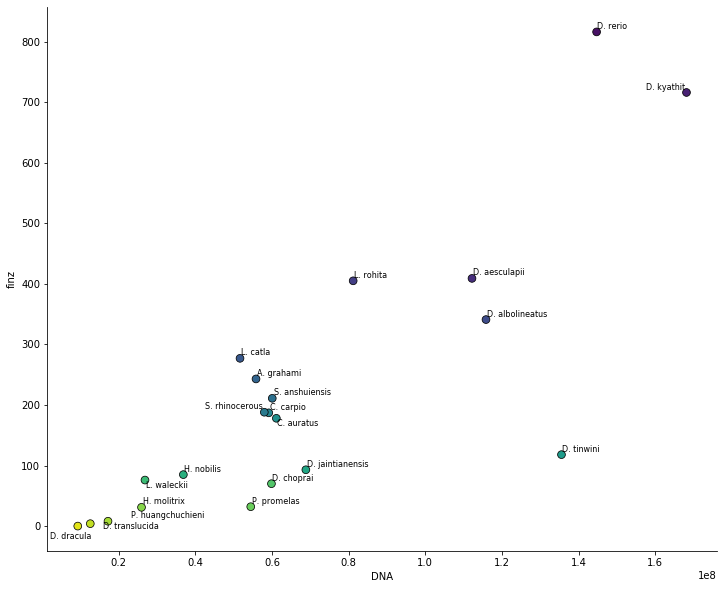

SpearmanrResult(correlation=0.7935064935064934, pvalue=1.768533345040275e-05)


In [381]:
column = 'DNA'
fig, ax = plt.subplots(figsize=(12, 10))
sns.scatterplot(data=count_df, 
                x=column, 
                y='finz',
                hue='species',
                palette='viridis_r',
                edgecolor='k',
                s=60,
                ax=ax)
ax.get_legend().remove()

labels = []
for row in count_df.iterrows():
    label = row[1]['species'].split('_')[0][0] +'. '+ row[1]['species'].split('_')[1]
    labels.append(ax.text(row[1][column], row[1]['finz'], label, size=8, va='center', ha='center'))
adjust_text(labels)

sns.despine()
plt.show()
print(stats.spearmanr(count_df[column], 
                      count_df['finz']))

In [351]:
y = count_df['DNA'].values.reshape(-1, 1) 
X = count_df['LTR'].values.reshape(-1, 1) 
lm = LinearRegression().fit(X, y)

count_df['pred_DNA'] = lm.predict(X).reshape(-1, 1)
count_df['resid_DNA'] = count_df['DNA'] - count_df['pred_DNA']


In [376]:
features = ['finz', 'DNA', 'LTR', 'LINE', 'SINE', 'Helitron']
X = count_df[features].values
sc = StandardScaler() 
X = sc.fit_transform(X)
pca = PCA()
pca.fit(X)
explained_variance = pca.explained_variance_ratio_ 
cv = pca.get_covariance()
print(cv)

[[1.05       0.8616877  0.81172611 0.60814079 0.62897719 0.626415  ]
 [0.8616877  1.05       0.91491984 0.80956593 0.84685153 0.54264331]
 [0.81172611 0.91491984 1.05       0.93842709 0.82770534 0.75191296]
 [0.60814079 0.80956593 0.93842709 1.05       0.70013942 0.66615108]
 [0.62897719 0.84685153 0.82770534 0.70013942 1.05       0.43736488]
 [0.626415   0.54264331 0.75191296 0.66615108 0.43736488 1.05      ]]
